In [22]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="/content/drive/MyDrive/ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="/content/drive/MyDrive/ratings_test.txt")

('/content/drive/MyDrive/ratings_test.txt',
 <http.client.HTTPMessage at 0x7fce819c2d10>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
train_data.drop_duplicates(subset = ['document'], inplace = True)

In [ ]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [ ]:
train_data['label'].value_counts()

0    73342
1    72840
Name: label, dtype: int64

In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ ㄱ-하-ㅣ가-힣0-9]", "")
train_data[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
train_data['document'] = train_data['document'].str.replace('^ +', '')
train_data['document'].replace('', np.nan, inplace = True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


id            0
document    646
label         0
dtype: int64


In [ ]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145536


In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace = True)
test_data['document'] = test_data['document'].str.replace('[^ ㄱ-ㅎㅏ-ㅣ가-힣]', '')
test_data['doucment'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace = True)
test_data = test_data.dropna(how = 'any')
print(len(test_data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


48995


In [37]:
stopwords = pd.read_table('/content/drive/MyDrive/stopwordlist.txt', header = None)
stopwords_list = list(stopwords[0])

In [107]:
import pickle
import os

okt = Okt()

X_train = []
X_test = []
if not os.path.isfile('/content/drive/MyDrive/text_mining_test.pkl'):
  for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords_list]
    X_train.append(stopwords_removed_sentence)
  with open("/content/drive/MyDrive/text_mining_train.pkl","wb") as f:
    pickle.dump(X_train, f)
  for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords_list]
    X_test.append(stopwords_removed_sentence)
  with open("/content/drive/MyDrive/text_mining_test.pkl","wb") as f:
      pickle.dump(X_test, f)
else:
    with open("/content/drive/MyDrive/text_mining_train.pkl","rb") as f:
        X_train = pickle.load(f)
    with open("/content/drive/MyDrive/text_mining_test.pkl", "rb") as f:
        X_test = pickle.load(f)  

In [108]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [109]:
print(len(tokenizer.word_index))

45815


In [110]:
threshold = 5
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 : ', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수 : %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 : ', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : ', (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 :  45815
등장 빈도가 4번 이하인 희귀 단어의 수 : 31315
단어 집합에서 희귀 단어의 비율 :  68.3509767543381
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :  2.9660175176264723


In [111]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  14501


In [112]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [113]:
print(X_train[:3])

[[49, 426, 22, 237, 626], [904, 429, 41, 570, 1, 194, 1422, 31, 930, 640, 26], [365, 2431, 2302, 5544, 2, 201, 16]]


In [114]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [115]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 11.239096138610451


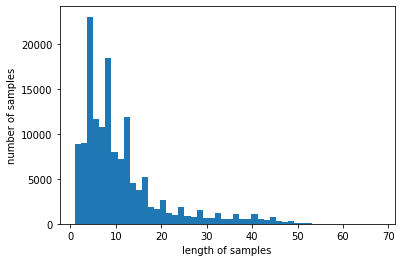

In [116]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [117]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 97.61565223381902


In [118]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 512
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('text_mining_LSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
 152/1796 [=>............................] - ETA: 4:47 - loss: 0.5192 - acc: 0.7307

In [120]:
def get_nouns(tokenizer, sentence):
    tagged = tokenizer.pos(sentence)
    words = [s for s, t in tagged if t in ['Adjective', 'Determiner', 'Exlamation', 'Hashtag', 'KoreanParticle', 'Noun',
                                           'Verb', 'Adverb'] and len(s) > 1]
    return words

In [121]:
def tokenize(df):
    tokenizer = Okt()
    processed_data = []
    for sent in tqdm(df['document']):
        processed_data.append(get_nouns(tokenizer, sent))

    return processed_data

In [122]:
from konlpy.tag import Okt

pos_list = tokenize(train_data)

100%|██████████| 145536/145536 [13:37<00:00, 178.01it/s]


In [123]:
pos_test_list = tokenize(test_data)

100%|██████████| 48995/48995 [05:07<00:00, 159.19it/s]


In [124]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pos_list)

In [125]:
print(tokenizer.word_index)

{'영화': 1, '너무': 2, '정말': 3, '진짜': 4, '연기': 5, '평점': 6, '최고': 7, '스토리': 8, '생각': 9, '드라마': 10, '감동': 11, '사람': 12, '하는': 13, '보고': 14, '배우': 15, 'ㅋㅋ': 16, '감독': 17, '재미': 18, '내용': 19, '그냥': 20, '이런': 21, '없는': 22, '쓰레기': 23, '시간': 24, '봤는데': 25, '작품': 26, '사랑': 27, '하나': 28, '없다': 29, '다시': 30, '마지막': 31, '좋은': 32, '이건': 33, '같은': 34, '완전': 35, '정도': 36, '입니다': 37, '있는': 38, 'ㅠㅠ': 39, '처음': 40, 'ㅋㅋㅋ': 41, '장면': 42, '액션': 43, '주인공': 44, '이렇게': 45, '보는': 46, '최악': 47, '지금': 48, '이야기': 49, '봐도': 50, '느낌': 51, '연출': 52, 'ㅡㅡ': 53, '없고': 54, '명작': 55, '별로': 56, '역시': 57, '재밌게': 58, '이해': 59, '이영화': 60, '보면': 61, '많이': 62, '때문': 63, '여자': 64, '해서': 65, '보기': 66, '기억': 67, '결말': 68, '같다': 69, 'ㅎㅎ': 70, '아깝다': 71, '마음': 72, '인생': 73, '소재': 74, '없이': 75, '수준': 76, '현실': 77, '한번': 78, '가장': 79, '매력': 80, '반전': 81, '전개': 82, '한다': 83, '한국': 84, '남자': 85, '가슴': 86, '되는': 87, '아이': 88, '음악': 89, '하게': 90, '원작': 91, '만든': 92, '인간': 93, '우리': 94, '무슨': 95, '추천': 96, '눈물': 97, '않고': 98, '합니다': 99, '봤다'

In [126]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 : ', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수 : %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 : ', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : ', (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 :  97317
등장 빈도가 2번 이하인 희귀 단어의 수 : 66747
단어 집합에서 희귀 단어의 비율 :  68.58719442646198
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :  6.818520440405057


In [127]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  30571


In [128]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(pos_list)
X_train = tokenizer.texts_to_sequences(pos_list)
X_test = tokenizer.texts_to_sequences(pos_test_list)

In [129]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [130]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 67
리뷰의 평균 길이 : 7.575866222039668


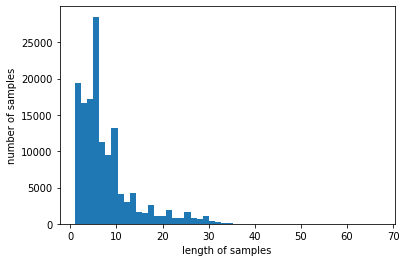

In [131]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [132]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 99.32888242214966


In [133]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [136]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 512
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('text_mining_LSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1796/1796 [==============================] - ETA: 0s - loss: 0.3939 - acc: 0.8188
Epoch 1: val_acc improved from -inf to 0.84528, saving model to text_mining_LSTM.h5
1796/1796 [==============================] - 510s 282ms/step - loss: 0.3939 - acc: 0.8188 - val_loss: 0.3504 - val_acc: 0.8453
Epoch 2/15
1796/1796 [==============================] - ETA: 0s - loss: 0.2718 - acc: 0.8837
Epoch 2: val_acc did not improve from 0.84528
1796/1796 [==============================] - 510s 284ms/step - loss: 0.2718 - acc: 0.8837 - val_loss: 0.3638 - val_acc: 0.8440
Epoch 3/15
1796/1796 [==============================] - ETA: 0s - loss: 0.1908 - acc: 0.9202
Epoch 3: val_acc did not improve from 0.84528
1796/1796 [==============================] - 519s 289ms/step - loss: 0.1908 - acc: 0.9202 - val_loss: 0.4451 - val_acc: 0.8374
Epoch 4/15
 617/1796 [=========>....................] - ETA: 5:07 - loss: 0.1195 - acc: 0.9534

KeyboardInterrupt: ignored